In [1]:
"""Project: Data_Science_Receipt_Identification"""

'Project: Data_Science_Receipt_Identification'

In [2]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import csv

%matplotlib inline

In [4]:
file = 'training_data.csv'
reader = csv.reader(open(file))
samples = []
for line in reader:
    samples.append(line)
print(len(samples), samples[0])
samples = samples[1:]
print(samples[0][0] + '.jpg')

ch, row, col = 3, 66, 220

images = []
labels = []
for sample in tqdm(samples):
    image_path = 'images/' + sample[0] + '.jpg'
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (col, row), interpolation=cv2.INTER_AREA)

    images.append(resized_image)

    label = sample[-1]
    labels.append(label)
print('images and labels read.')    

  0%|          | 0/4502 [00:00<?, ?it/s]

4503 ['EXT_ID', 'STORENAME', 'IsWalmart']
58c47902e4b06d16e3cd3541.jpg


100%|██████████| 4502/4502 [27:17<00:00,  3.14it/s]

images and labels read.


In [6]:
'''One hot encoding'''
# file = 'training_data.csv'
# reader = csv.reader(open(file))
# samples = []
# for line in reader:
#     samples.append(line)
# samples = samples[1:]
# labels = []
# for sample in samples:
#     labels.append(sample[-1])
    
from keras.utils.np_utils import to_categorical
labels = labels[1:]
images = images[1:]

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
# convert integers to dummy variables (i.e. one hot encoded)
one_hot_labels = to_categorical(encoded_labels)
print(one_hot_labels)

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


100%|██████████| 4500/4500 [00:00<00:00, 15574.66it/s]


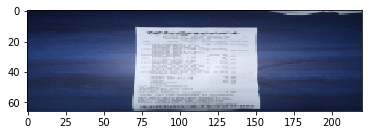

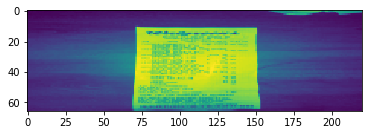

In [10]:
'''Image Preprocessing, resize to 66x220, BGR to Gray'''
preprocessed_images = []
for i in tqdm(range(len(images))):
    image = images[i]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    preprocessed_images.append(gray)

n = 1000
plt.imshow(images[n])    
plt.show()
plt.imshow(preprocessed_images[n])
plt.show()

4500
Number of images used: 4500
[ 1.  0.]


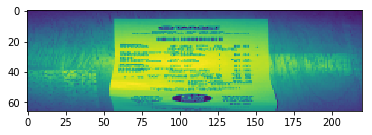

In [11]:
'''Read data, Generate samples'''
samples = list(zip(preprocessed_images, one_hot_labels)) # zip two lists for convenience

print(len(samples))
print('Number of images used:',len(samples))
plt.imshow(samples[0][0])
print(samples[0][1])

In [12]:
print(len(samples))
print(len(one_hot_labels))

4500
4500


In [30]:
'''Generator'''
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print(len(train_samples), len(validation_samples))

import sklearn
from sklearn.utils import shuffle
ch, row, col = 3, 240, 320  #
ch, row, col = 3, 120, 160  #
ch, row, col = 3, 66, 220
# ch, row, col = 3, 340, 640 # not resize
# ch, row, col = 3 170, 320 #  resize to half

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        # shuffle the data
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            isWalmarts = []
            for batch_sample in batch_samples:
                # read image and append images
#                 image_filename = batch_sample[0]
#                 image = cv2.imread(image_filename)
#                 image = cv2.resize(image, (col, row), interpolation=cv2.INTER_AREA)
                
                image = batch_sample[0]
                image = np.reshape(image, (66, 220, 1))
                
                images.append(image)

                isWalmart = batch_sample[1]
                isWalmarts.append(isWalmart)    
                
                # # flip image to generalize
                # image_flipped = np.fliplr(image)
                # images.append(image)
                # speeds.append(speed)

            X_train = np.array(images)
            y_train = np.array(isWalmarts)


            # print(X_train[0].shape)
            # print(len(X_train), len(y_train))
            yield sklearn.utils.shuffle(X_train, y_train)


# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

3600 900


In [31]:
'''
Nvidia using old version of keras
'''
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
ch, row, col = 1, 66, 220

input_shape = (row, col, ch)

# input_shape = (row, col)
def train_Nvidia(input_shape):
    """
    Train the model using nvidia architecture
    """
    print("train using nvidia model")
    model = Sequential()
    model.add(Lambda(lambda x:x / 127.5 - 0.5, input_shape=input_shape))

    model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(2,2), activation="relu"))
#     model.add(BatchNormalization(axis=-1))
    model.add(Convolution2D(36, 5, 5, border_mode="valid", subsample=(2,2), activation="elu"))
#     model.add(BatchNormalization(axis=-1))
    model.add(Convolution2D(48, 5, 5, border_mode="valid", subsample=(2,2), activation="elu"))
#     model.add(BatchNormalization(axis=-1))
    model.add(Convolution2D(64, 3, 3, border_mode="valid", activation="elu"))
#     model.add(BatchNormalization(axis=-1))
    model.add(Convolution2D(64, 3, 3, border_mode="valid", activation="elu"))
#     model.add(BatchNormalization(axis=-1))

    model.add(Flatten())
#     model.add(BatchNormalization())
    model.add(Dense(100, activation="elu"))
    model.add(Dense(50, activation="elu"))
    model.add(Dense(10, activation="elu"))
#     model.add(BatchNormalization())
#     model.add(Dense(1, activation="linear"))
#     model.add(Dense(1, activation="sigmoid"))
    model.add(Dense(2, activation="softmax"))

    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
#     model.compile(loss='mse', optimizer=adam)
    model.compile(loss='binary_crossentropy', optimizer=adam)


    
    filepath = 'nvidia-model.h5'
    earlyStopping = EarlyStopping(monitor='val_loss', 
                                  patience=1, 
                                  verbose=1, 
                                  min_delta = 0.23,
                                  mode='min',)
    modelCheckpoint = ModelCheckpoint(filepath, 
                                      monitor = 'val_loss', 
                                      save_best_only = True, 
                                      mode = 'min', 
                                      verbose = 1
                                     )
#                                      save_weights_only = False)
    callbacks_list = [modelCheckpoint, earlyStopping]

    # history = model.fit_generator(
    #         train_generator, 
    #         steps_per_epoch = 400, 
    #         epochs = 25,
    #         callbacks = callbacks_list,
    #         verbose = 1,
    #         validation_data = valid_generator,
    #         validation_steps = val_size)
    history_object = model.fit_generator(
                        train_generator, 
#                         steps_per_epoch = 400, 

                        samples_per_epoch=len(train_samples), 
                        validation_data=validation_generator,
                        nb_val_samples=len(validation_samples), 
                        nb_epoch=25,
                        callbacks = callbacks_list)
    model.summary()

    # save the model
#     os.chdir('.')
#     model.save('model_opticalFlow_66_220.h5')
    print ('saved')
    return history_object, model
history_object, model = train_Nvidia(input_shape)  

train using nvidia model
Epoch 1/25
3600/3600 [==============================] - 51s - loss: 0.5181 - val_loss: 0.3827
Epoch 2/25
3600/3600 [==============================] - 37s - loss: 0.2813 - val_loss: 0.1993
Epoch 3/25
3600/3600 [==============================] - 61s - loss: 0.1753 - val_loss: 0.1544
Epoch 00002: early stopping
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_12 (Lambda)               (None, 66, 220, 1)    0           lambda_input_12[0][0]            
____________________________________________________________________________________________________
convolution2d_44 (Convolution2D) (None, 31, 108, 24)   624         lambda_12[0][0]                  
____________________________________________________________________________________________________
convolution2d_45 (Convolution2D) (None, 14, 52, 36)    2163

dict_keys(['val_loss', 'loss'])


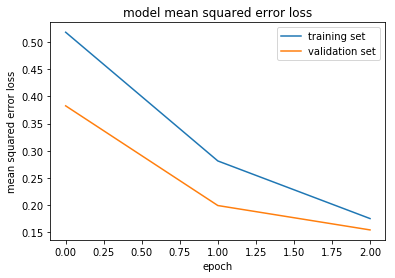

In [32]:
'''visualization'''
### print the keys contained in the history object
print(history_object.history.keys())


### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [35]:
'''
prediction
'''
from keras.models import load_model
ch, row, col = 3, 66, 220

model_name = 'nvidia-model.h5'
model = load_model(model_name)
image_name = 'images/58a0deb9e4b0314ab22f9906.jpg'
# image_name = 'images/58b61e0ee4b0d23e37734d43.jpg'
image = cv2.imread(image_name)
image = cv2.resize(image, (col, row), interpolation=cv2.INTER_AREA)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = np.reshape(image, (66, 220, 1))

image_array = np.asarray(image)
# resize
#         image_array = cv2.resize(image_array, (col, row), interpolation=cv2.INTER_AREA)
# predict
print(model.predict_classes(image_array[None, :, :, :])[0])
# prediction = float(model.predict(image_array[None, :, :, :], batch_size=1))
# print(prediction)
print(np.max(model.predict_proba(image_array[None, :, :, :])))
isWalmart = model.predict_classes(image_array[None, :, :, :])[0]
prob = np.max(model.predict_proba(image_array[None, :, :, :]))
print(isWalmart, prob)

1/1 [==============================] - 0s
1
1/1 [==============================] - 0s
0.99888
1/1 [==============================] - 0s
1 0.99888


In [39]:
file = 'test_data.csv'
reader = csv.reader(open(file))
samples = []
for line in reader:
    samples.append(line)
print(len(samples), samples[0])
samples = samples[1:]
print(samples[0][0] + '.jpg')

ch, row, col = 3, 66, 220

test_images_dic = {}
labels = []
for sample in tqdm(samples):
    image_path = 'images/' + sample[0] + '.jpg'
    image = cv2.imread(image_path)
    image = cv2.resize(image, (col, row), interpolation=cv2.INTER_AREA)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.reshape(image, (66, 220, 1))

    test_images_dic[sample[0]] = image

print('test images read.') 



  0%|          | 0/1500 [00:00<?, ?it/s]

1501 ['EXT_ID', 'IsWalmart']
58ab4fc9e4b08c6e1ec0a94d.jpg



100%|██████████| 1500/1500 [07:56<00:00,  3.62it/s]

test images read.


In [40]:
data = []
for image_name, test_image in test_images_dic.items():
    prediction = model.predict_classes(test_image[None, :, :, :])[0]
    if prediction == 1:
        isWalmart = 'TRUE'
    else:
        isWalmart = 'FALSE'
    prob = np.max(model.predict_proba(test_image[None, :, :, :]))
    data.append(image_name + ',' + isWalmart + ',' + str(prob) + '\n')
    
with open("results.csv", "w") as csv_file:
#         writer = csv.writer(csv_file, delimiter=',')
    csv_file.write('EXT_ID,WalmartReceipt,PredictionScore\n')

    for line in data:
        csv_file.write(line)
            
print('results are written to csv.')

1/1 [==============================] - 0s
results are written to csv.
